# OFDM: Orthogonal Frequency Division Multiplexing

Este código apresenta uma implementação de um sistema de comunicação OFDM elementar, considerando um canal AWGN simples.

In [132]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, ifft, fftshift, fftfreq
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.metrics import signal_power, fastBERcalc
from utils.dsp import firFilter, pulseShape#, lowPassFIR
from utils.models import mzm
from commpy.utilities  import signal_power, upsample

In [133]:
def lowPassFIR(fc, fa, N, typeF = 'rect'):
    """
    Calculate FIR coeffs for a lowpass filter
    
    :param fc : cutoff frequency
    :param fa : sampling frequency
    :param N  : number of coefficients
    :param typeF : 'rect' or 'gauss'
    
    :return h : FIR filter coefficients
    """
    fu = fc/fa    
    d  = (N-1)/2    
    n  = np.arange(0, N)    
  
    # calculate filter coefficients
    if typeF == 'rect':
        h = (2*fu)*np.sinc(2*fu*(n-d))
    elif typeF == 'gauss':    
        h = np.sqrt(2*np.pi/np.log(2))*fu*np.exp(-(2/np.log(2))*(np.pi*fu*(n-d))**2)
    
    return h

In [134]:
def awgn(tx, noiseVar):
    
    σ        = np.sqrt(noiseVar)
    noise    = np.random.normal(0,σ, tx.size) + 1j*np.random.normal(0,σ, tx.size)
    noise    = 1/np.sqrt(2)*noise
    
    rx = tx + noise
    
    return rx

### 1 - Transmissão

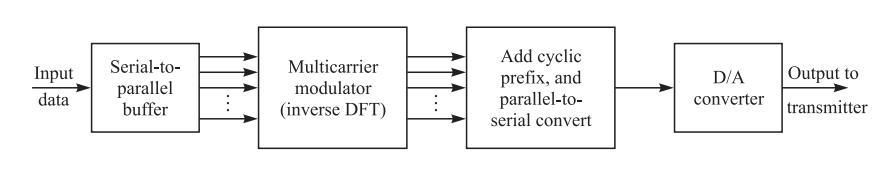

Assumindo que temos uma banda de $W\ Hz$  disponível para transmissão, dividiremos esta em $N/2$ partes de largura $\Delta f = 2W/N$, e em cada parte destas enviaremos um símbolo diferente com portadora $f_k = k/T$ ($k = 0, 1, \dots, N/2 - 1$) centrada em cada intervalo, isso com uma taxa de $1/T\ Hz$. A cada sub-portadora, podemos associar um tipo de modulação separadamente. Por exemplo, digamos que tenhamos $N/2 = 4$ sub-portadoras, assim, poderíamos associar a cada uma delas uma constelação M-QAM, como ilustrado na Figura abaixo.

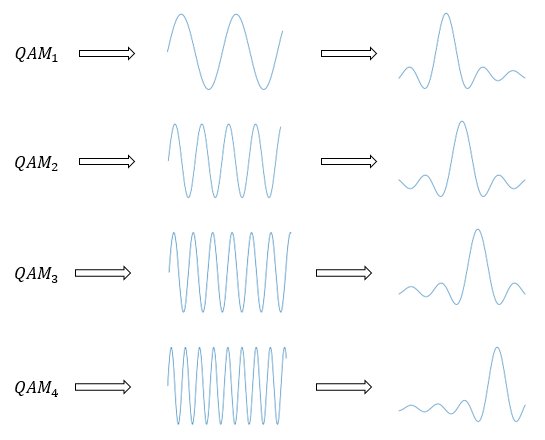

Como as frequências das portadoras são separadas em múltiplos de $1/T$, a seguinte propriedade é válida:
    
$$
\begin{equation}
    \int_0^T \cos(2\pi f_nt + \phi_n)\cos(2\pi f_mt + \phi_m)dt = 0, \text{ se } f_n - f_m = \dfrac{k}{T}
\end{equation}
$$

Daí que se deriva a denominação de portadoras ortogonais. Cada símbolo das constelações M-QAM pode ser representado matematicamente da seguinte forma:

\begin{align*}
s_k(t) = \sqrt{\dfrac{2}{T}}A_{k_i}\cos(2\pi f_kt) - \sqrt{\dfrac{2}{T}}A_{k_q}\sin(2\pi f_kt) &= 
Re \left\{ \sqrt{\dfrac{2}{T}}\sqrt{A_{k_i}^2 + A_{k_q}^2}e^{\theta_k}e^{j2\pi f_k t}  \right\} = \\ 
&=Re\left\{ \sqrt{\dfrac{2}{T}}X_ke^{j2\pi f_kt}  \right\} 
\end{align*}

Como temos $N/2$ portadoras, o sinal OFDM na saída do transmissor é:

\begin{equation}
    s(t) = \sum_{k=0}^{N/2 - 1} Re\left\{ \sqrt{\dfrac{2}{T}}X_ke^{j2\pi f_kt}\right\}
\end{equation}

Uma manipulação geralmente feita nos esquemas OFDM consiste em expandir o tamanho do pacote para $2\cdot N/2 = N$ símbolos, isso adicionando conjugados complexos dos símbolos originais seguindo a regra abaixo:

\begin{equation}
    \begin{cases}
        X_{N - i} = X_i^*\ , \quad \text{para } i = 1, 2, \dots , N/2 - 1 \\
        X_0 = Re\{ X_0 \} \\
        X_{N/2} = Im\{ X_0 \}
    \end{cases}
\end{equation}

Essa operação nos permite garantir que o sinal $s(t)$ será puramente real.
\begin{equation}\label{eq:saida_ofdm}
    s(t) = \sqrt{\dfrac{2}{T}}\sum_{k=0}^{N - 1} X_ke^{j\tfrac{2\pi k t}{T}}
\end{equation}

Repare que o sinal de saída tem uma expressão muito semelhante à da transformada discreta inversa de Fourier (IDFT), dada por:
\begin{equation}
    x_n = \dfrac{1}{\sqrt{N}}\sum_{k=0}^{N-1} X_ke^{j\tfrac{2\pi kn}{N}}
\end{equation}

De fato, $s(t)$ amostrado nos intervalos de tempo $t = nT/N$ e multiplicado por um fator adequado equivale à IDFT dos $N$ símbolos $X_k$ das constelações M-QAM de entrada, portanto, não é necessário que o transmissor possua um quadro de osciladores representando cada uma das $N/2$ sub-portadoras, e sim de um bloco capaz de realizar a operação de IFFT sobre o conjunto de símbolos de entrada.

É muito usual também a adição de uma banda de guarda aos símbolos transmitidos, isso com o intuito de prevenir interferência intersimbólica e entre portadoras. O processo consiste em adicionar ao começo do pacote (já processado pelo bloco IFFT) $G$ símbolos redundantes ($x_{N-G}, x_{N-G - 1}, \dots, x_{N-1}$), logo, o conjunto $\{x_{N-G}, \dots, x_{N-1} , x_0, x_1,\dots, x_{N-1}  \}$ será transmitido.

In [135]:
# Parâmetros da simulação
SpS = 32                   # Amostras coletadas por segundo
Rs  = 10e9                 # Taxa de símbolos
Ts  = 1/Rs                 # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)           # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa                 # Período de amostragem

In [136]:
# Sinalização original: M-QAM
M = 64
constType = 'qam'

constSymb = GrayMapping(M, constType)
bitMap = demodulateGray(constSymb, M, constType)
bitMap = bitMap.reshape(-1, int(np.log2(M)))

# Gera sequência de bits aleatórios
bits = np.random.randint(2, size = 6*2**14)

# Mapeia os bits nos símbolos da constelação (log2(M) = k bits por símbolo)
symbTx = modulateGray(bits, M, constType) #/ np.sqrt(signal_power(symbTx))
Es = signal_power(symbTx)
symbTx = symbTx / np.sqrt(Es)

In [137]:
# Paralelizando a informação em pacotes de N símbolos obedecendo uma simetria hermitiana
N = 32            # Tamanho dos blocos de informação (são N/2 subportadoras!)
G = int(M/8)      # Tamanho do prefixo cíclico

symbTx_P = np.zeros((int(len(symbTx)/(N/2)), N + G), complex)
aux = 0

for i in range(len(symbTx_P)):
    symbTx_P[i,G:G+int(N/2)] = symbTx[int(aux):int(aux+N/2)]  # Cada linha da matriz symbTx_P é um conjunto de N/2 símbolos QAM, equivalente a 1 símbolo OFDM
    aux = aux + N/2
    
    # Simetria hermitiana
    v = symbTx_P[i,G]
    symbTx_P[i,G] = v.real
    symbTx_P[i,G + int(N/2)] = v.imag 
    
    for j in range(int(N/2)-1):
        j = j + 1
        symbTx_P[i,G + int(N) - j] = np.conjugate(symbTx_P[i,G + j])
        
    # Aplicação da IFFT
    symbTx_P[i,G:N+G] = ifft(symbTx_P[i,G:N+G])
    
    # Adição do prefixo cíclico
    symbTx_P[i,:] = np.concatenate((symbTx_P[i,N:N+G],symbTx_P[i,G:N+G]))

In [138]:
# Conversão Paralelo -> Serial e formatação de pulso
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

symbolsUp = upsample(np.squeeze(symbTx_P.reshape(1,len(symbTx_P[0])*len(symbTx_P))), SpS)
sigTx = firFilter(pulse, symbolsUp)

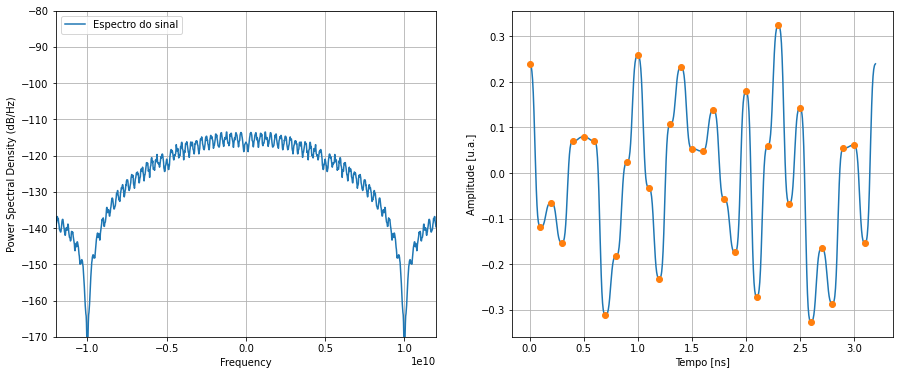

In [139]:
fig, axs = plt.subplots(1, 2, figsize=(15,6))

t = np.arange(0, sigTx.size)*(Ta/1e-9)
idX = np.arange(0,1024)

axs[0].set_xlim(-1.2*Rs,1.2*Rs)
axs[0].set_ylim(-170,-80)
axs[0].psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigTx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

axs[1].plot(t[idX][0::SpS],symbolsUp[idX][0::SpS].real,'o')

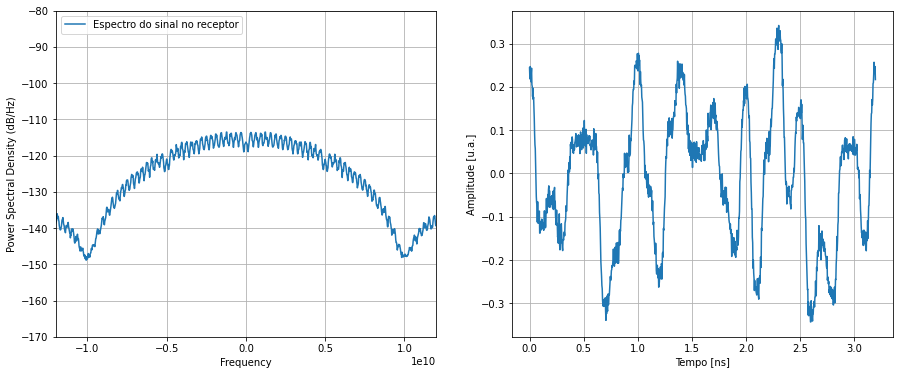

In [140]:
# Canal AWGN
EbN0dB = 25
snrdB    = EbN0dB + 10*np.log10(np.log2(M))
noiseVar = 1/(10**(snrdB/10))

sigRx = awgn(sigTx, noiseVar)

fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].set_xlim(-1.2*Rs,1.2*Rs)
axs[0].set_ylim(-170,-80)
axs[0].psd(sigRx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal no receptor')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigRx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

### 2 - Recepção

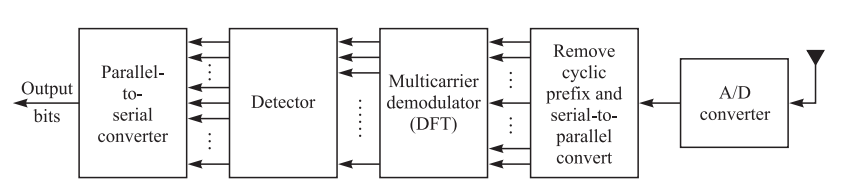

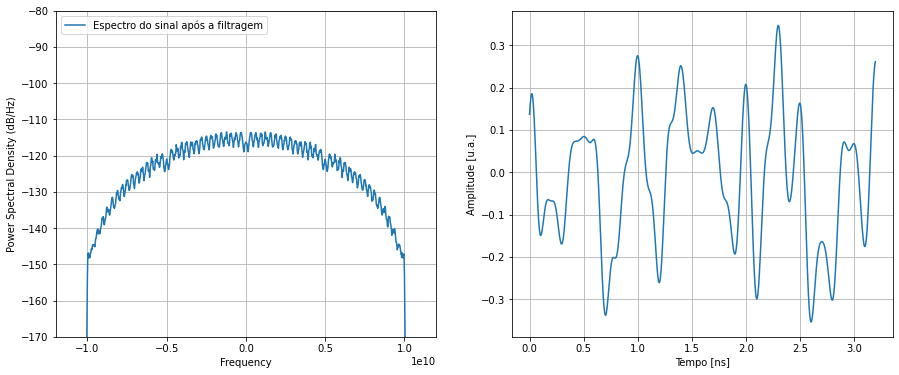

In [141]:
B = 10e9    # Banda do filtro de entrada

n = 8001
h = lowPassFIR(B, Fa, n, typeF='rect')  # Coeficiente do filtro passa-baixa

sigRx  = firFilter(h, sigRx)

fig, axs = plt.subplots(1, 2, figsize=(15,6))

axs[0].set_xlim(-1.2*Rs,1.2*Rs)
axs[0].set_ylim(-170,-80)
axs[0].psd(sigRx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal após a filtragem')
axs[0].legend(loc='upper left')

axs[1].plot(t[idX], sigRx[idX].real)
axs[1].set_xlabel('Tempo [ns]')
axs[1].set_ylabel('Amplitude [u.a.]')
axs[1].grid(True)

In [142]:
# Separando as amostras
symbRx = sigRx[0::SpS]

# Conversão Serial -> Paralelo
symbRx_P = np.zeros((int(len(symbRx)/(N+G)), N), complex)
aux = 0

for i in range(len(symbRx_P)):
    symbRx_P[i,0:N] = symbRx[aux+G:aux+N+G]   # Retirando o prefixo cíclico e paralelizando a informação
    aux = aux + N + G

    # Aplicação da FFT
    symbRx_P[i,:] = fft(symbRx_P[i,:])

In [143]:
# Conversão Paralelo -> Serial
symbRx_S = np.zeros(int(len(symbRx_P[0])*len(symbRx_P)/2), complex)
aux = 0

# Retirada da simetria hermitiana
for i in range(len(symbRx_P)):
    symbRx_S[int(aux):int(aux + N/2)] = symbRx_P[i,0:int(N/2)]
    aux = aux + N/2

Er = signal_power(symbRx_S)

In [144]:
# Retirada dos tons piloto
symbRx_S[0::int(N/2)] = 'nan'
symbTx[0::int(N/2)] = 'nan'

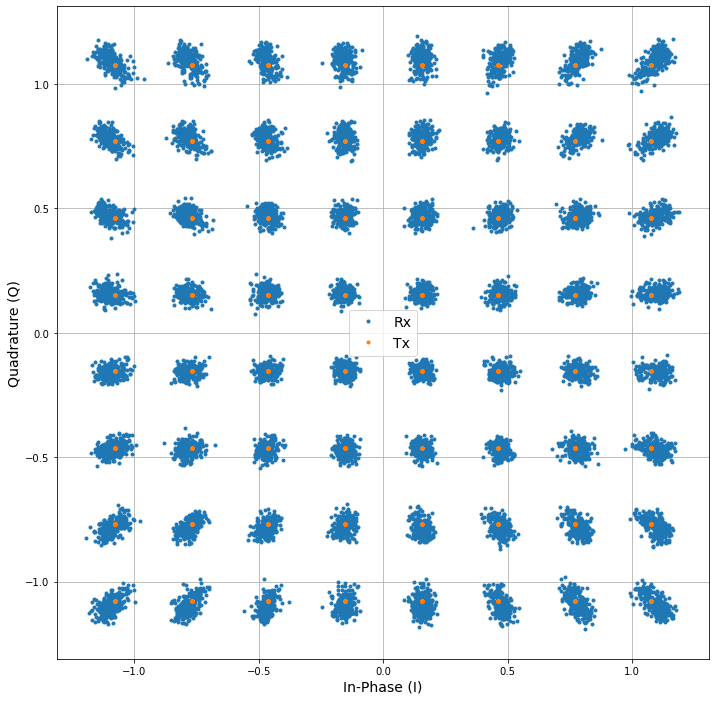

In [145]:
plt.figure(figsize=(12,12))
plt.plot(symbRx_S.real/np.sqrt(Er), symbRx_S.imag/np.sqrt(Er),'.', label='Rx')
plt.plot(symbTx.real, symbTx.imag,'.', label='Tx')
plt.axis('square')
plt.xlabel('In-Phase (I)', fontsize = 14)
plt.ylabel('Quadrature (Q)', fontsize = 14)
plt.legend(fontsize = 14);
plt.grid()

#for ind, symb in enumerate(constSymb/np.sqrt(Es)):
#    bitMap[ind,:]
#    plt.annotate(str(bitMap[ind,:])[1:-1:2], xy = (symb.real, symb.imag))

In [146]:
bitTx = demodulateGray(symbRx_S*np.sqrt(Es), M, constType)
bitRx = demodulateGray(symbTx*np.sqrt(Es), M, constType)

discard = 100
BER = np.logical_xor(bitRx[discard:len(bitRx)-discard], bitTx[discard:len(bitTx)-discard]).mean()
BER

4.077305716382615e-05